https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

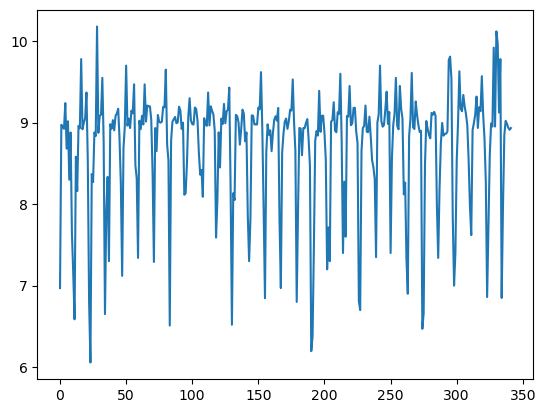

In [2]:
# df = pd.read_csv('data/airline-passengers.csv')
# timeseries = df[["Passengers"]].values.astype('float32')
df = pd.read_csv('../data/missoula_valley_wells_imputed_qreg.csv')
timeseries = df[['151081']].dropna().values.astype('float32')
plt.plot(timeseries)

In [3]:
timeseries.shape

(342, 1)

In [37]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[0:train_size], timeseries[train_size:len(timeseries)]

In [38]:
def create_dataset(dataset, look_back):
    """Transform a time series into a prediction dataset using a window based on the 
    look_back parameter.

    Args:
        dataset: A numpy array of time series, first dimension is the time steps 
        look_back: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        feature = dataset[i:i + look_back]
        target = dataset[i+1:i + look_back+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [66]:
lookback = 36
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([193, 36, 1]) torch.Size([193, 36, 1])
torch.Size([77, 36, 1]) torch.Size([77, 36, 1])


In [70]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        # extract only the last time step
        # x = x[:, -1, :]
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_pred = model(X_train)
        y_train = y_train.to(device)
        y_test = y_test.to(device)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().numpy())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().numpy())
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 6.8169, test RMSE 6.8556
Epoch 100: train RMSE 0.6235, test RMSE 0.6263
Epoch 200: train RMSE 0.6060, test RMSE 0.6028
Epoch 300: train RMSE 0.5997, test RMSE 0.6028
Epoch 400: train RMSE 0.5024, test RMSE 0.5391
Epoch 500: train RMSE 0.4966, test RMSE 0.5210
Epoch 600: train RMSE 0.4885, test RMSE 0.5423
Epoch 700: train RMSE 0.4643, test RMSE 0.4993
Epoch 800: train RMSE 0.4603, test RMSE 0.4814
Epoch 900: train RMSE 0.4205, test RMSE 0.5167
Epoch 1000: train RMSE 0.3705, test RMSE 0.5154
Epoch 1100: train RMSE 0.3467, test RMSE 0.5292
Epoch 1200: train RMSE 0.3162, test RMSE 0.5265
Epoch 1300: train RMSE 0.3008, test RMSE 0.5413
Epoch 1400: train RMSE 0.3044, test RMSE 0.5533
Epoch 1500: train RMSE 0.2842, test RMSE 0.5603
Epoch 1600: train RMSE 0.2767, test RMSE 0.5578
Epoch 1700: train RMSE 0.2742, test RMSE 0.5758
Epoch 1800: train RMSE 0.2856, test RMSE 0.5666
Epoch 1900: train RMSE 0.2621, test RMSE 0.5853


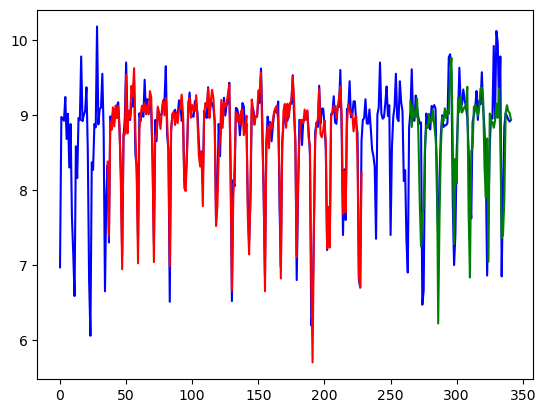

In [72]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train).cpu().numpy()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).cpu().numpy()[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()